# Улучшение процесса обогащения золота
## Постановка задачи

Заказчиком является инжиниринговая компания, которая разрабатывает решения для эффективной работы промышленных предприятий.

Требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Данные
В нашем распоряжении имеются данные с параметрами добычи и очистки. 

Данные находятся в трёх файлах:
- **gold_recovery_train.csv** — обучающая выборка;
- **gold_recovery_test.csv** — тестовая выборка;
- **gold_recovery_full.csv** — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.<br/>
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.<br/>

Данные в нашем распоряжении являются сырыми: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, требуется проверить их на корректность согласно согласованной с заказчиком инструкции.

## Наименование признаков
Наименование признаков строится по следующему правилу:

`[этап].[тип_параметра].[название_параметра]`
    

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- **rougher** — флотация
- **primary_cleaner** — первичная очистка
- **secondary_cleaner** — вторичная очистка
- **final** — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- **input** — параметры сырья
- **output** — параметры продукта
- **state** — параметры, характеризующие текущее состояние этапа
- **calculation** — расчётные характеристики

## План работы

0. Загрузить библиотеки.<br/>
0.1. Потребуются библиотеки pandas, matplotlib, sklearn


1. Подготовка данных<br/>
1.1. Открыть и изучить файлы.<br/> 
1.2. Провести предобработку данных. Убрать или заменить пропуски, привести данные к нужным типам.<br/>
1.3. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчитанным и имеющимся значением признака. Описать выводы.<br/>
1.4. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?<br/>


2. Проанализировать данные<br/>
2.1. Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.<br/>
2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. **Если распределения сильно отличаются друг от друга, оценка модели будет неправильной**.<br/>
2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Проверить, есть ли аномальные значения в суммарном распределении. Определить, если они есть, следует ли их удалять из обеих выборок? Описать выводы и удалить аномалии в соответствии с принятыми правилами, если найдутся.


3. Построить модель<br/>
3.1. Написать функцию для вычисления итоговой **sMAPE**.<br/>
3.2. Обучить разные модели и оценить их качество кросс-валидацией.<br/> 
3.3. Выбрать лучшую модель и проверить её на тестовой выборке.<br/> 
3.4. Описать выводы.

## Формулы
Требуется использовать следующие формулы для вычисления метрик качества.<br/>

Эффективность обогащения рассчитывается по формуле:

$$
Recovery = {{C \times (F - T)} \over {F \times (C - T)}} \times 100\%
$$

где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Для решения задачи введём новую метрику качества — **sMAPE** (Symmetric Mean Absolute Percentage Error - симметричное среднее абсолютное процентное отклонение).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных и одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

$$
sMAPE = {1 \over N} \sum\limits_{i=1}^N {{|y_i - y'_i|} \over {(|y_i| + |y'_i|) / 2}} \times 100\%
$$

При работе над проектом требуется спрогнозировать сразу две величины эффективности обогащения:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика sMAPE складывается из двух величин:

$$
Final\_sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
$$

# 0. Загрузка библиотек

In [1]:
# import libraries
import pandas as pd
import numpy as np
from numpy.random import RandomState
from scipy.stats import gaussian_kde

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import graphics
import matplotlib.pyplot as plt

import copy

print('Importing libraries - OK')

Importing libraries - OK


Необходимые библиотеки загружены.

# 1. Подготовка данных

План работы:

1.1. Открыть и изучить файлы.<br/> 
1.2. Провести предобработку данных. Убрать или заменить пропуски, привести данные к нужным типам.<br/>
1.3. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчитанным и имеющимся значением признака. Описать выводы.<br/>
1.4. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?<br/>

## 1.1. Открыть и изучить файлы.
Чтобы открыть файлы, воспользуемся заклинанием read_csv.

In [2]:
# opening files
data_gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

print('data_gold_recovery_train.shape =', data_gold_recovery_train.shape)
print('data_gold_recovery_test.shape =', data_gold_recovery_test.shape)
print('data_gold_recovery_full.shape =', data_gold_recovery_full.shape)

data_gold_recovery_train.shape = (16860, 87)
data_gold_recovery_test.shape = (5856, 53)
data_gold_recovery_full.shape = (22716, 87)


Файлы загружены. Посмотрим на структуру данных. Если смотреть по размерностям, то количество строк полной выборки складывется из количества строк обучающей и тестовой выборок. Количество столбцов в обучающей и полной выорках совпадают. В тестовой выборке некоторые столбцы отсутствуют.

In [3]:
print(data_gold_recovery_train.info())
print()
print(data_gold_recovery_test.info())
print()
print(data_gold_recovery_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Становится более понятно, какие столбцы отсутстуют в тестовой выборке. Это все столбцы типов `output` и `calculation`.

Столбец `date` имеет строковый тип во всех выборках. Требуется перевести в дату. 

В столбцах некоторые значения пропущены. 

Теперь пойдём по плану.

## 1.2. Предобработка данных
Что следует сделать:
- Исследовать на пропуски, убрать или заменить
- Привести данные к нужным типам

### 1.2.1. Пропуски
Из общей информации понятно, что пропуски есть почти во всенх столбцах, но их немного. Не ясно пока, размещены ли они в одних строках или распределены по наборам данных хаотично. От этого зависит, какую стратегию выбрать: удалять или заменять на разумные значения.

Используя 20-летний опыт работы с технологическими производственными данными сделаем следующее предположение. Технологические параметры **всегда** поступают непрерывным потоком и с привязкой во времени. Отсутствие данных в архиве может говорить о том, что в какой-то период времени у системы АСУТП не было связи с сервером данных и она не смогла их туда поместить. Так как у самой АСУТП объёмы памяти ограничены, а новые данные поступают неотвратимо, как с конвейера, прошлые данные теряются. Исходя из природы технологических данных :
- Во-первых, признаки меняются во времени непрерывно и постепенно и не дают выбросов; если выброс, то это авария или неисправность датчика.
- Во-вторых, пропуски могут идти периодами во времени, захватывая несколько соседних тайм фреймов.
- В-третьих, пропущена будет вся порция данных для тайм фрейма разом.

Исходя из вышеизложенного, разумным значением для заполнения пропусков будет ближайшее предыдущее значение. 

Сделаем функцию fillna и обработаем пропуски.

In [4]:
def fillna(dataset, columns=None):
    """
    Fills Nan with the nearest previous not Nan value
        parameters:
        - columns - list of column names to fill Nan; None means all dataset columns
        returns: filled dataset
    """
    if columns == None:
        dataset.fillna(method='ffill', axis=0, inplace=True)
    else:
        for col in columns:
            dataset[col].fillna(method='ffill', axis=0, inplace=True)
            
    return dataset

# filling na data_gold_recovery_train
fillna(data_gold_recovery_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 16860 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                                  16860 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant             

In [5]:
# filling na data_gold_recovery_test
fillna(data_gold_recovery_test).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
rougher.in

In [6]:
# filling na data_gold_recovery_full
fillna(data_gold_recovery_full).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22716 non-null float64
final.output.concentrate_pb                           22716 non-null float64
final.output.concentrate_sol                          22716 non-null float64
final.output.concentrate_au                           22716 non-null float64
final.output.recovery                                 22716 non-null float64
final.output.tail_ag                                  22716 non-null float64
final.output.tail_pb                                  22716 non-null float64
final.output.tail_sol                                 22716 non-null float64
final.output.tail_au                                  22716 non-null float64
primary_cleaner.input.sulfate                         22716 non-null float64
primary_cleaner.input.depressant             

Пропуски заполнены.

### 1.2.2. Приведение типов данных
Один лишь тип данных нам надо преобразовать - это строку в дату-время в колонке `date`.

Сделаем функцию `to_datetime` и произведём операцию над всеми датасетами. И превратим поле даты в индекс для всех наборов. Это соответствует природе данных.

In [7]:
def to_datetime(dataset, date_column_name=None):
    """
    Converts string type to date-time type in a given column
        parameters:
        - date column name as string; None means "date" by default
        returns: dataset index
        """
    if date_column_name == None:
        date_column_name = 'date'
            
    # 2016-02-15 02:00:00
    dataset[date_column_name] = pd.to_datetime(dataset[date_column_name], format='%Y-%m-%d %H:%M:%S')
    dataset.set_index(date_column_name, drop=True, append=False, inplace=True, verify_integrity=True)
    return dataset.index

print('data_gold_recovery_train index type -', to_datetime(data_gold_recovery_train).dtype.name)
print('data_gold_recovery_test index type -', to_datetime(data_gold_recovery_test).dtype.name)
print('data_gold_recovery_full index type -', to_datetime(data_gold_recovery_full).dtype.name)

data_gold_recovery_train index type - datetime64[ns]
data_gold_recovery_test index type - datetime64[ns]
data_gold_recovery_full index type - datetime64[ns]


Отлично, с приведением колонки `date` закончили.

## 1.3. Проверить, что эффективность обогащения расчитана правильно
План на раздел такой:<br/>
- Вычислить эффективность обогащения на обучающей выборке для признака `rougher.output.recovery`. 
- Найти **MAE** между расчитанным и имеющимся значением признака. 
- Описать выводы.

Для начала посмотрим, как распределены данные в признаках `rougher.input.feed_au`, `rougher.output.concentrate_au`, `rougher.output.tail_au`, которые потребуются для расчёта. Нет ли выбросов и других неправильных значений.

Для этого сделаем функцию `plot_feature_boxes`.

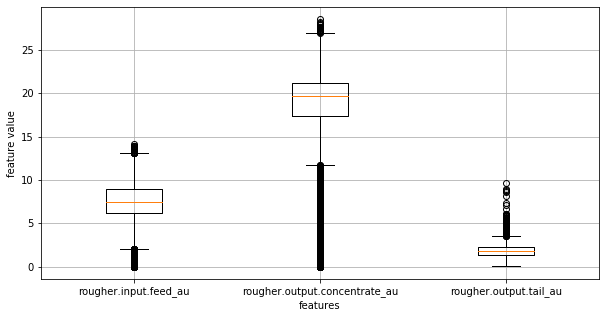

In [8]:
def plot_feature_boxes(dataset, axe, feature_list):
    """
    Creates a boxplot with given feature names
        parameters:
        - dataset - dataset to plot columns from
        - axe object to add plots into
        - feature_list - list with name of feature
        returns: axe object
    """
    series = []
    for i in feature_list:
        series.append(dataset[i])
        
    axe.boxplot(series, labels=feature_list)
    axe.grid(True)
    axe.set_xlabel('features')
    axe.set_ylabel('feature value')
    
    return axe

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

feature_list = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']

axes = plot_feature_boxes(data_gold_recovery_train, axes, feature_list)

fig.show()

Статистическое распределение признаков выглядит хорошо. 

В то же время смущает наличие нулевых значений в колонке `rougher.input.feed_au`. Чтобы понять, что тревожит, углубимся в физическую природу процесса и данных. Исследуем, как взаимосвязаны между собой параметры концентрации в пульпе (будем так называть feed), концентрате (concentrate) и хвостах (tail).

Золото (особенно золото) подчиняется закону сохранения массы, как любая материальная сущность. Поэтому масса золота в пульпе, пришедшей на обогащение, равна сумме масс золота в концентрате и хвостах. Это можно выразить следующим образом:

**m_feed_au = m_concantrate_au + m_tail_au** (1), где
- m_feed_au - масса золота во входной пульпе,
- m_concantrate_au - масса золота в концентрате после разделения,
- m_tail_au - масса золота, ушедшая в хвосты после разделения.

Формула справедлива как для отдельной ступени очистки, так и для всей цепочки.
Показатели концентрации **F**, **C**, **T**, участвующие в формуле вычисления эффективности обогащения, показывают долю ценного металла в общей массе пульпы. Учитывая это, формулу сохранения массы золота можно переписать следующим образом:

**F * m_feed = C * m_concantrate + T * (m_feed - m_concantrate)** (2), где
- m_feed - масса пульпы на входе,
- m_concantrate - масса концентрата после разделения
- F, C, T - показатели концентрации металла в пульпе, концентрате и хвостах соответственно.

Из формулы 2 можно сделать следующие выводы:
- Признаки **F**, **C**, **T** являются коллинеарными и любой из них можно выразить через два других.
- Нулевое значение **F** означает, что во входящей пульпе нет металла, значит **С** и **Т** тоже должны быть равны нулю.
- Правая часть не может быть отрицательной, так как m_feed >= m_concentrate всегда.

Держа в уме сделанные выводы, посмотрим значения полей `rougher.output.concentrate_au`, `rougher.output.tail_au` и `rougher.output.recovery` в тех строках, где поле `rougher.input.feed_au` равно нулю.

In [9]:
data_gold_recovery_train[data_gold_recovery_train['rougher.input.feed_au'] == 0][
    ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
     'rougher.output.tail_au', 'rougher.output.recovery']].describe()

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery
count,1213.0,1213.000000,1213.000000,1213.000000
mean,0.0,0.536315,2.183541,58.847609
std,0.0,3.134011,0.858417,32.888826
min,0.0,0.000000,0.734503,0.000000
25%,0.0,0.000000,1.464155,26.275908
50%,0.0,0.000000,1.994817,68.920897
75%,0.0,0.000000,2.692304,88.651062
max,0.0,24.470183,5.964024,92.804566


Имеем 1213 явных несоответствий признаков `rougher.input.feed_au`, `rougher.output.concentrate_au`, `rougher.output.tail_au` между собой. Признаку `rougher.output.recovery` они так же не соответствуют, потому что при отсутствии металла на входе коэффициент обогащения не может отличаться от нуля.

Следует обратить внимание заказчика на такое несоответствие данных. Причина скорее всего в том, что признаки `rougher.input.feed_au`, `rougher.output.concentrate_au`, `rougher.output.tail_au`, с одной стороны, и признак `rougher.output.recovery`, с другой стороны, попадают в производственную базу данных разными путями из разных систем. Где-то произошёл сбой и данные испортились. Также возможно искажение данных при формировании выборок. Следует посоветоваться с заказчиком, что делать с несоответствующими данными и разработать методы проверки всех данных на корректность.

А пока будем работать с тем, что есть. Так как признак `rougher.output.recovery` не может быть равен 0, будем считать, что эти строки содержат неверные данные. Так же исключим из расчёта строки, в которых признаки `rougher.output.concentrate_au`, 
            `rougher.input.feed_au`, `rougher.output.tail_au`, `rougher.output.recovery` отсутствуют.

In [10]:
def recovery_rougher1(df, c, f, t):
    #c = "rougher.output.concentrate_au"
    #f = "rougher.input.feed_au"
    #t = "rougher.output.tail_au"
    return ((df[c] * (df[f] - df[t])) / (df[f] * (df[c] - df[t]))) * 100
    
data = pd.read_csv('/datasets/gold_recovery_train.csv')
data = (data[data["rougher.output.recovery"] != 0])[["rougher.output.concentrate_au", 
            "rougher.input.feed_au", "rougher.output.tail_au", "rougher.output.recovery"]].dropna()

c_recovery = recovery_rougher1(data, "rougher.output.concentrate_au", "rougher.input.feed_au", "rougher.output.tail_au")

mae = mean_absolute_error(data["rougher.output.recovery"], c_recovery)
print(f"MAE: {mae:.2f}")

MAE: 0.00


Параметр `recovery` в наборе данных вычислен верно.

## 1.4. Проанализировать признаки, недоступные в тестовой выборке. 
Требуется ответить на вопросы:<br/>
1.4.1. Что это за параметры? <br/>
1.4.2. К какому типу относятся?

### 1.4.1. Что это за параметры?
Составим список полей, отсутствующих в тестовой выборке.

In [11]:
missing_columns = []

for col in data_gold_recovery_full.columns:
    if col not in data_gold_recovery_test.columns:
        missing_columns.append(col)
        
missing_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

### 1.4.2. К какому типу относятся?
Этого и следовало ожидать - в тестовой выборке отсутствуют все признаки, которые являются вторичными. 

Что имеется в виду. Технологические параметры можно разбить на две группы:
- Первичные - получаются путём прямого измерения параметров технологического процесса с помощью приборов и другим способом их получить нельзя.
- Вторичные - вычисляются из первичных или, даже если измеряются, могу быть вычислены из первичных.

К первичным признакам относятся такие параметры, как уровень пульпы, расход воздуха, размер гранул, расход ингибиторов и т.п. Ко вторичным признакам относятся параметры концентрации, коэффициенты обогащения, как общие, так и по ступеням. Они и отсутствуют в тестовом датасете.

И оно и к лучшему. Как мы убедились, доверять им нельзя.

Так как параметры концентрации и коэффициенты обогащения напрямую зависят от первичных параметров, первичных параметров вполне достаточно для построения модели.

# 2. Анализ данных
Теперь следует проанализировать данные.

План на раздел:<br/>

2.1. Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.<br/>

2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. **Если распределения сильно отличаются друг от друга, оценка модели будет неправильной**.<br/>

2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Проверить, есть ли аномальные значения в суммарном распределении. Определить, если они есть, следует ли их удалять из обеих выборок? Описать выводы и удалить аномалии в соответствии с принятыми правилами, если найдутся.

## 2.1. Изучить концентрацию металлов
Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, и описать выводы.

Следует сделать таблицу - металл - этап - концентрация на разных стадиях и сделать столбчатую диаграмму.

Разобьём признаки по категорим - пульпа, концентрат, хвосты - и по установкам - rougher, primary_cleaner, secondary_cleaner - чтобы понять, как группировать признаки.

|Установка         |Пульпа на вход        |Концентрат                    |Хвосты                 |
|:-----------------|:-------------------- |:-----------------------------|:----------------------|
|rougher           |rougher.input.feed_ag |rougher.output.concentrate_ag |rougher.output.tail_ag |
|                  |rougher.input.feed_pb |rougher.output.concentrate_pb |rougher.output.tail_pb |
|                  |rougher.input.feed_au |rougher.output.concentrate_au |rougher.output.tail_au |
|                  |                           |
|primary_cleaner   |rougher.output.concentrate_ag |primary_cleaner.output.concentrate_ag |primary_cleaner.output.tail_ag |
|                  |rougher.output.concentrate_pb |primary_cleaner.output.concentrate_pb |primary_cleaner.output.tail_pb |
|                  |rougher.output.concentrate_au |primary_cleaner.output.concentrate_au |primary_cleaner.output.tail_au |
|                  |
|secondary_cleaner |primary_cleaner.output.concentrate_ag |final.output.concentrate_ag |secondary_cleaner.output.tail_ag |
|                  |primary_cleaner.output.concentrate_ag |final.output.concentrate_pb |secondary_cleaner.output.tail_pb |
|                  |primary_cleaner.output.concentrate_ag |final.output.concentrate_au |secondary_cleaner.output.tail_au |

Сформируем табличку, содержащую средние значения концентраций в означенных местах. Для этого сделаем функцию. Чтобы проверить функцию, заполним табличку названиями колонок.

In [12]:
def filling_concentration_table(dataset, metals, units, types, value='names'):
    """
    Creates and fills a table with values of concentration by kind of product and unit
        parameters:
        - dataset - input dataset to select data from
        - metals - list of metal names
        - units - list of production unit names
        - types - list of product names
        - value - type of value to pick up, "names" means column names (for testing), "mean" means mean value
        returns: a dataset
    """
    columns = ['metal', 'unit', 'feed', 'concentrate', 'tail']
    features = []

    # completing list of features
    # for every metal
    for metal in metals:
        # for every unit
        for unit in units:
            # create a row and put the metal and unit names
            row = []
            row.append(metal)
            row.append(unit)
            
            # most interesting - make column name of the dataset for values to be posted in the row 
            #      feed/concentrate/tail columns
            feed_name = ''
            concentrate_name = ''
            tail_name = ''
            for kind in types:
                if unit == 'rougher':
                    if kind == 'feed':
                        feed_name = unit + '.input.feed_' + metal
                    elif kind == 'concentrate':
                        concentrate_name = unit + '.output.' + kind + '_' + metal
                    else:
                        tail_name = unit + '.output.' + kind + '_' + metal
                elif unit == 'primary_cleaner':
                    if kind == 'feed':
                        feed_name = 'rougher.output.concentrate_' + metal
                    elif kind == 'concentrate':
                        concentrate_name = unit + '.output.' + kind + '_' + metal
                    else:
                        tail_name = unit + '.output.' + kind + '_' + metal
                else:
                    if kind == 'feed':
                        feed_name = 'primary_cleaner.output.concentrate_' + metal
                    elif kind == 'concentrate' :
                        concentrate_name = 'final.output.concentrate_' + metal
                    else:
                        tail_name = unit + '.output.' + kind + '_' + metal
                        
            # fill names
            if value == 'names':
                row.append(feed_name)
                row.append(concentrate_name)
                row.append(tail_name)
            # fill means
            else:
                row.append(dataset[feed_name].mean())
                row.append(dataset[concentrate_name].mean())
                row.append(dataset[tail_name].mean())
                
            features.append(row)
    
    features = pd.DataFrame(features)
    features.columns = columns
    return features
    
# labels
metals = ['ag', 'pb', 'au']
units = ['rougher', 'primary_cleaner', 'secondary_cleaner']
types = ['feed', 'concentrate', 'tail']

# to test the function let's fill with column names
filling_concentration_table(data_gold_recovery_full, metals, units, types)

,metal,unit,feed,concentrate,tail
0,ag,rougher,rougher.input.feed_ag,rougher.output.concentrate_ag,rougher.output.tail_ag
1,ag,primary_cleaner,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,primary_cleaner.output.tail_ag
2,ag,secondary_cleaner,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,secondary_cleaner.output.tail_ag
3,pb,rougher,rougher.input.feed_pb,rougher.output.concentrate_pb,rougher.output.tail_pb
4,pb,primary_cleaner,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,primary_cleaner.output.tail_pb
5,pb,secondary_cleaner,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,secondary_cleaner.output.tail_pb
6,au,rougher,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au
7,au,primary_cleaner,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_au
8,au,secondary_cleaner,primary_cleaner.output.concentrate_au,final.output.concentrate_au,secondary_cleaner.output.tail_au


Методом прямого сличения истины убедждаемся, что названия признаков стоят там, где надо, значит функция работает.

Зарядим теперь её расчитать средние значения концентраций по полному датасету. Исключим строки, где концентрация металла во входной пульпе равна нулю. Как сделали вывод прежде, таким строкам доверять нельзя.

In [13]:
concentration_mean = filling_concentration_table(
    data_gold_recovery_full[(data_gold_recovery_full['rougher.input.feed_ag'] != 0) &
                           (data_gold_recovery_full['rougher.input.feed_pb'] != 0) &
                           (data_gold_recovery_full['rougher.input.feed_au'] != 0)], 
    metals, units, types, 'mean')
concentration_mean

,metal,unit,feed,concentrate,tail
0,ag,rougher,8.648048,11.633380,5.590071
1,ag,primary_cleaner,11.633380,8.204262,15.845157
2,ag,secondary_cleaner,8.204262,5.072346,14.254828
3,pb,rougher,3.530530,7.388530,0.633333
4,pb,primary_cleaner,7.388530,9.429633,3.381274
5,pb,secondary_cleaner,9.429633,9.667326,5.653940
6,au,rougher,8.114044,19.129225,1.835478
7,au,primary_cleaner,19.129225,31.142632,3.901125
8,au,secondary_cleaner,31.142632,42.567739,4.297862


Изобразим полученные данные на столбчатой диаграмме, по диаграмме для каждого металла.

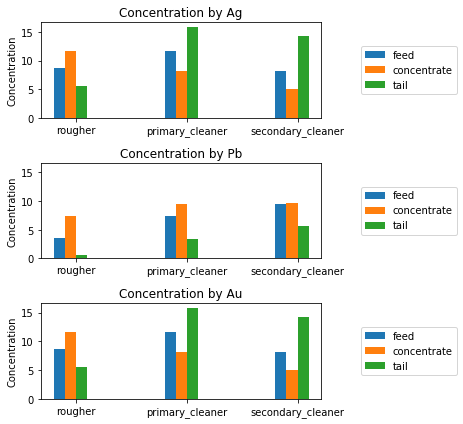

In [14]:
def plot_concentrations(concentration_dataset, ax, units, types):
    """
    Plots metal concentration bar chart by units and type of raw material
        parameters:
        - concentration_dataset - input dataset
        - ax - axe object to draw in
        - units - production unit list
        - types - kind of product list
        returns: axe object
    """
    x = np.arange(len(units))  # the label locations
    width = 0.1
    bar_offset = (len(units) / 2 - len(units)) * width  # the width of the bars

    rects = []
    for kind in types:
        rects.append(ax.bar(x + bar_offset, concentration_dataset[kind], width, label=kind))
        bar_offset += width

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Concentration')
    ax.set_xticks(x)
    ax.set_xticklabels(units)
    ax.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))
    
    return ax

fig, ax = plt.subplots(3, 1, figsize=(7.5, 6), sharey=True)
plot_concentrations(concentration_mean[concentration_mean['metal'] == 'ag'], ax[0], units, types)
ax[0].set_title('Concentration by Ag')
plot_concentrations(concentration_mean[concentration_mean['metal'] == 'pb'], ax[1], units, types)
ax[1].set_title('Concentration by Pb')
plot_concentrations(concentration_mean[concentration_mean['metal'] == 'ag'], ax[2], units, types)
ax[2].set_title('Concentration by Au')

fig.tight_layout()
fig.show()

Диаграмма демонстриует странную картину. Следовало бы ожидать, что концентрация в концентрате должна повышаться от ступени к ступени, а концентрация в хвостах - понижаться. У нас же обратная картина. Если истолковать её в производственных ьерминах, то получается, что обогатительная фабрика обедняет сырьё и сваливает основной продукт в хвосты.

Более-менее похожей на правду выглядит только картина для свинца. Но и здесь концентрация металла в хвостах растёт, что противоречит природе процесса.

В то же время показатели концентрации и эффективности обогащения являются основными производственными показателями. Фабрики бьются за повышение эффективности на доли процента, это сулит премии, повышения по службе и прочие приятности. А здесь такое.

Остаётся сделать окончательный вывод, что настоящие показатели концентрации присутствуют где-то в других системах, а те, что попали к нам, являются недостоверными и обучать модель по ним нельзя.

Теперь посмотрим на это с другой стороны.

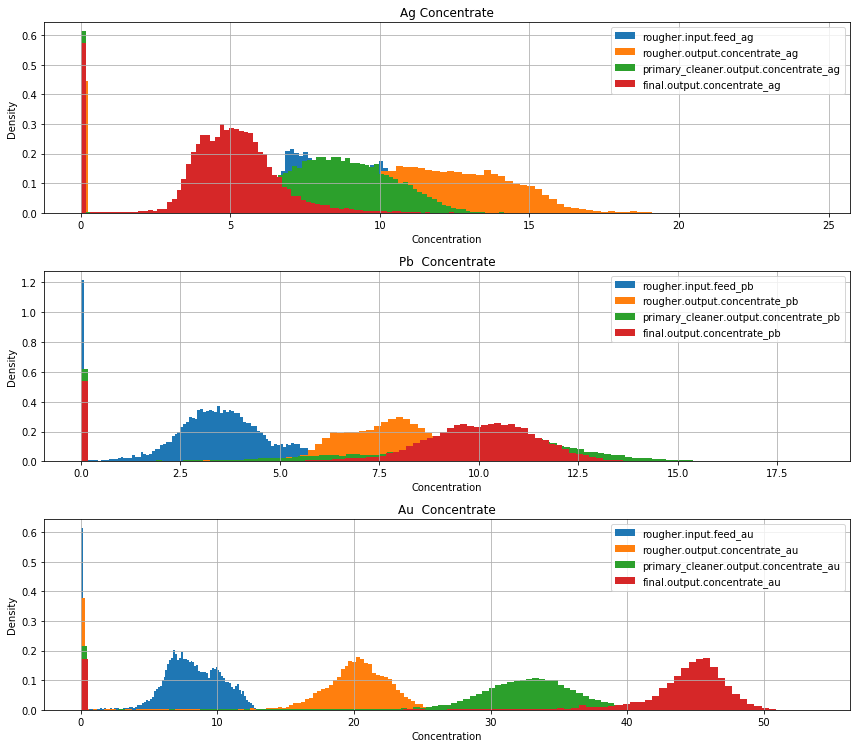

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10.5))
ax[0].set_title('Ag Concentrate')
ax[0].hist(data_gold_recovery_full['rougher.input.feed_ag'], density=True, bins=100, label='rougher.input.feed_ag')
ax[0].hist(data_gold_recovery_full['rougher.output.concentrate_ag'], density=True, bins=100, label='rougher.output.concentrate_ag')
ax[0].hist(data_gold_recovery_full['primary_cleaner.output.concentrate_ag'], density=True, bins=100, label='primary_cleaner.output.concentrate_ag')
ax[0].hist(data_gold_recovery_full['final.output.concentrate_ag'], density=True, bins=100, label='final.output.concentrate_ag')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Concentration')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('Pb  Concentrate')
ax[1].hist(data_gold_recovery_full['rougher.input.feed_pb'], density=True, bins=100, label='rougher.input.feed_pb')
ax[1].hist(data_gold_recovery_full['rougher.output.concentrate_pb'], density=True, bins=100, label='rougher.output.concentrate_pb')
ax[1].hist(data_gold_recovery_full['primary_cleaner.output.concentrate_pb'], density=True, bins=100, label='primary_cleaner.output.concentrate_pb')
ax[1].hist(data_gold_recovery_full['final.output.concentrate_pb'], density=True, bins=100, label='final.output.concentrate_pb')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Concentration')
ax[1].legend()
ax[1].grid(True)

ax[2].set_title('Au  Concentrate')
ax[2].hist(data_gold_recovery_full['rougher.input.feed_au'], density=True, bins=100, label='rougher.input.feed_au')
ax[2].hist(data_gold_recovery_full['rougher.output.concentrate_au'], density=True, bins=100, label='rougher.output.concentrate_au')
ax[2].hist(data_gold_recovery_full['primary_cleaner.output.concentrate_au'], density=True, bins=100, label='primary_cleaner.output.concentrate_au')
ax[2].hist(data_gold_recovery_full['final.output.concentrate_au'], density=True, bins=100, label='final.output.concentrate_au')
ax[2].set_ylabel('Density')
ax[2].set_xlabel('Concentration')
ax[2].legend()
ax[2].grid(True)

fig.tight_layout()
fig.show()

Так получилось нагляднее. По золоту плотности по оси распределены правильно, Чем выше стадия - тем выше концентрация. По свинцу финал практически совпал с с выходом первой очистки. То есть вторая ступень тонкой очистки на свинце не работает. А по серебру полная каша. Выход хуже, чем всё остальное.

Для полноты картины проверим ещё хвосты и добавим к ним опять же данные по питающей пульпе.

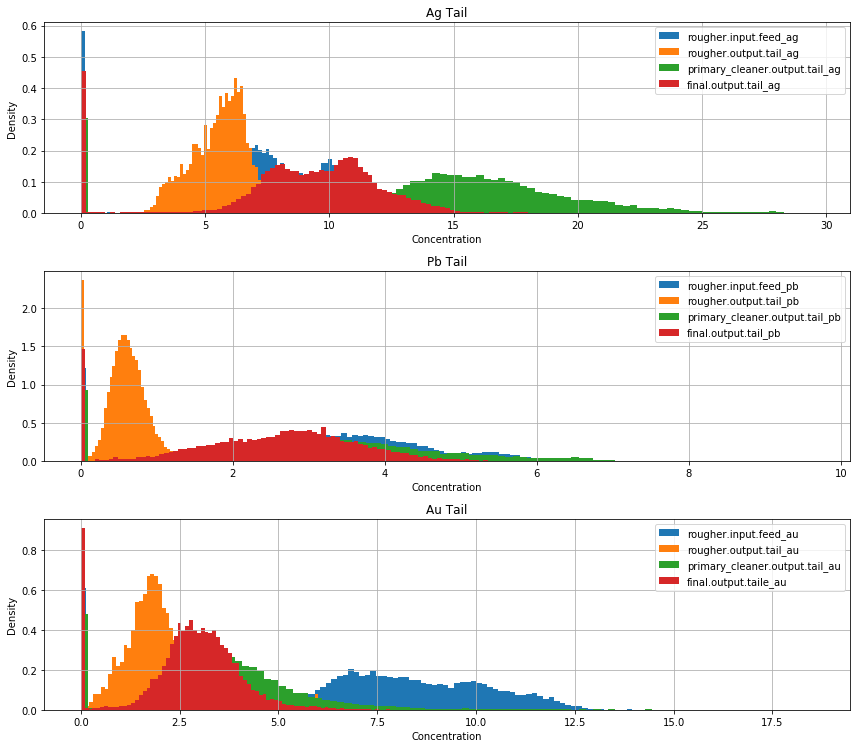

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10.5))
ax[0].set_title('Ag Tail')
ax[0].hist(data_gold_recovery_full['rougher.input.feed_ag'], density=True, bins=100, label='rougher.input.feed_ag')
ax[0].hist(data_gold_recovery_full['rougher.output.tail_ag'], density=True, bins=100, label='rougher.output.tail_ag')
ax[0].hist(data_gold_recovery_full['primary_cleaner.output.tail_ag'], density=True, bins=100, label='primary_cleaner.output.tail_ag')
ax[0].hist(data_gold_recovery_full['final.output.tail_ag'], density=True, bins=100, label='final.output.tail_ag')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Concentration')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('Pb Tail')
ax[1].hist(data_gold_recovery_full['rougher.input.feed_pb'], density=True, bins=100, label='rougher.input.feed_pb')
ax[1].hist(data_gold_recovery_full['rougher.output.tail_pb'], density=True, bins=100, label='rougher.output.tail_pb')
ax[1].hist(data_gold_recovery_full['primary_cleaner.output.tail_pb'], density=True, bins=100, label='primary_cleaner.output.tail_pb')
ax[1].hist(data_gold_recovery_full['final.output.tail_pb'], density=True, bins=100, label='final.output.tail_pb')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Concentration')
ax[1].legend()
ax[1].grid(True)

ax[2].set_title('Au Tail')
ax[2].hist(data_gold_recovery_full['rougher.input.feed_au'], density=True, bins=100, label='rougher.input.feed_au')
ax[2].hist(data_gold_recovery_full['rougher.output.tail_au'], density=True, bins=100, label='rougher.output.tail_au')
ax[2].hist(data_gold_recovery_full['primary_cleaner.output.tail_au'], density=True, bins=100, label='primary_cleaner.output.tail_au')
ax[2].hist(data_gold_recovery_full['final.output.tail_au'], density=True, bins=100, label='final.output.taile_au')
ax[2].set_ylabel('Density')
ax[2].set_xlabel('Concentration')
ax[2].legend()
ax[2].grid(True)

fig.tight_layout()
fig.show()

И здесь аналогичная картина. По золоту хвосты распределены левее питающей пульпы и это правильно. На свинце вторая ступень не работает. А серебро откровенно в хвосты утекает.

Впрочем, если учесть, что линия предназначена для обогащения золота и с основной задачей справляется, то это, возможно, приемлемо.

## 2.2. Сравнить распределения размеров гранул сырья 
Следует сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Это важно, потому что если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Для оценки распределения построим гистограмму по всем трём наборам данных.

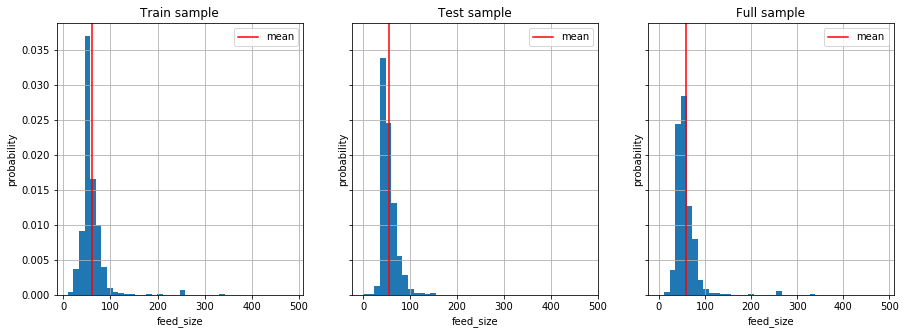

In [17]:
def plot_density(serie, axe, xlabel=None, title=None, kde=False):
    """
    Plots density histogram
        parameters:
        - serie - input data
        - axe - axe object to draw in
        returns: axe object
    """
    axe.hist(serie, density=True, bins=40)
    
    if xlabel != None:
        axe.set_xlabel(xlabel)
    if title != None:
        axe.set_title(title)

    if kde == True:
        density = gaussian_kde(serie)
        axe.plot(serie, density(serie), label='KDE')
        
    axe.axvline(x=serie.mean(), color='r', label='mean')
    axe.grid(True)
    axe.legend()

    axe.set_ylabel('probability')

    return axe

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plot_density(data_gold_recovery_train['rougher.input.feed_size'], axes[0], 'feed_size', 'Train sample')
plot_density(data_gold_recovery_test['rougher.input.feed_size'], axes[1], 'feed_size', 'Test sample')
plot_density(data_gold_recovery_full['rougher.input.feed_size'], axes[2], 'feed_size', 'Full sample')

fig.show()

Нельзя утверждать, что все три набора данных сильно отличаются по размеру частиц друг от друга. Посмотрим на цифры.

In [18]:
merged_size = pd.DataFrame(data_gold_recovery_full['rougher.input.feed_size'])
#merged_size.merge(data_gold_recovery_full['rougher.input.feed_size'])
merged_size = merged_size.merge(data_gold_recovery_train['rougher.input.feed_size'], how='outer', 
                                right_index=True, left_index=True)
merged_size = merged_size.merge(data_gold_recovery_test['rougher.input.feed_size'], how='outer', 
                                right_index=True, left_index=True)
merged_size.columns = ['full', 'train', 'test']
merged_size.describe()

,full,train,test
count,22716.000000,16860.000000,5856.000000
mean,59.082738,60.188595,55.898866
std,28.772748,30.522242,22.707969
min,0.046369,9.659576,0.046369
25%,46.671231,47.548897,43.852884
50%,53.356894,54.066003,49.964796
75%,64.315771,65.397249,61.628003
max,484.967466,484.967466,477.445473


По цифрам выборки сильно не различаются. Модель будет работать.

## 2.3. Исследовать суммарную концентрацию всех веществ 
Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Проверить, есть ли аномальные значения в суммарном распределении. Определить, если они есть, следует ли их удалять из обеих выборок? Описать выводы и удалить аномалии в соответствии с принятыми правилами, если найдутся.

Для исследования распределения снова воспользуемся гистограммой. У нас есть замечательная функция для этого.

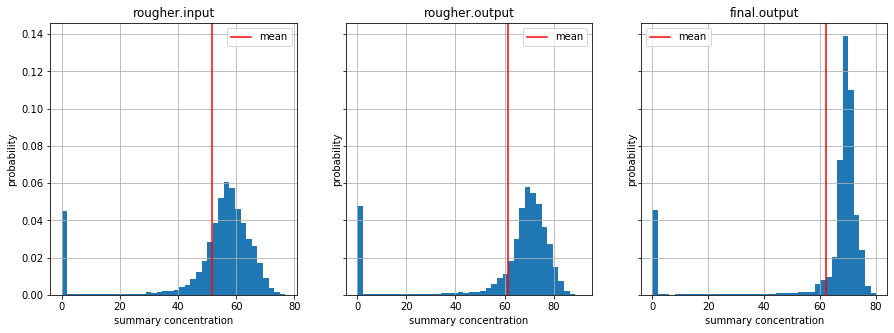

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

plot_density(data_gold_recovery_full['rougher.input.feed_ag'] + data_gold_recovery_full['rougher.input.feed_pb']
             + data_gold_recovery_full['rougher.input.feed_sol'] + data_gold_recovery_full['rougher.input.feed_au'], 
             axes[0], 'summary concentration', 'rougher.input')

plot_density(data_gold_recovery_full['rougher.output.concentrate_ag'] 
             + data_gold_recovery_full['rougher.output.concentrate_pb']
             + data_gold_recovery_full['rougher.output.concentrate_sol'] 
             + data_gold_recovery_full['rougher.output.concentrate_au'], 
             axes[1], 'summary concentration', 'rougher.output')

plot_density(data_gold_recovery_full['final.output.concentrate_ag'] 
             + data_gold_recovery_full['final.output.concentrate_pb']
             + data_gold_recovery_full['final.output.concentrate_sol'] 
             + data_gold_recovery_full['final.output.concentrate_au'], 
             axes[2], 'summary concentration', 'final.output')

fig.show()

Что видим - видим чётко различимый выброс в районе нуля. Посмотрим по продуктам отдельно.

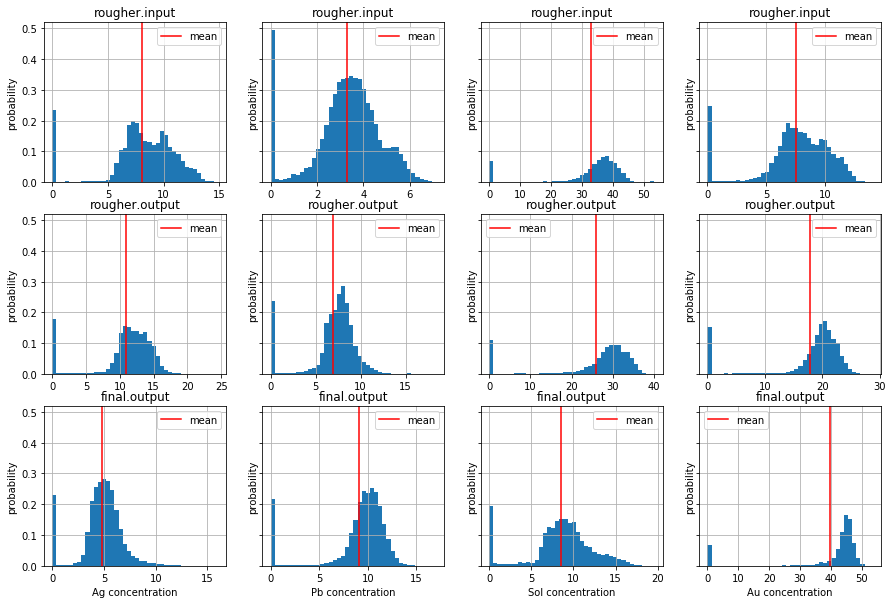

In [20]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharey=True)

# plotting rougher.input
plot_density(data_gold_recovery_full['rougher.input.feed_ag'], axes[0, 0], None, 'rougher.input')
plot_density(data_gold_recovery_full['rougher.input.feed_pb'], axes[0, 1], None, 'rougher.input')
plot_density(data_gold_recovery_full['rougher.input.feed_sol'], axes[0, 2], None, 'rougher.input')
plot_density(data_gold_recovery_full['rougher.input.feed_au'], axes[0, 3], None, 'rougher.input')

# plotting rougher.output
plot_density(data_gold_recovery_full['rougher.output.concentrate_ag'], axes[1, 0], None, 'rougher.output')
plot_density(data_gold_recovery_full['rougher.output.concentrate_pb'], axes[1, 1], None, 'rougher.output')
plot_density(data_gold_recovery_full['rougher.output.concentrate_sol'], axes[1, 2], None, 'rougher.output')
plot_density(data_gold_recovery_full['rougher.output.concentrate_au'], axes[1, 3], None, 'rougher.output')

# plotting final.output
plot_density(data_gold_recovery_full['final.output.concentrate_ag'], axes[2, 0], 'Ag concentration', 'final.output')
plot_density(data_gold_recovery_full['final.output.concentrate_pb'], axes[2, 1], 'Pb concentration', 'final.output')
plot_density(data_gold_recovery_full['final.output.concentrate_sol'], axes[2, 2], 'Sol concentration', 'final.output')
plot_density(data_gold_recovery_full['final.output.concentrate_au'], axes[2, 3], 'Au concentration', 'final.output')

fig.show()

Так и есть. Выбросы присутствуют во всех продуктах. Это подтверждает прежний вывод о том, что данные о концентрации испорчены и пользоваться ими нельзя. Мы и не будем. Обучим модель на первичных технологических параметрах.

Поэтому с выбросами концентрации делать ничего не станем. Отправим картинку заказчику, пусть думает.

# 3. Модель
Пришло время построить модель.

План работы, добавим в него ещё один пункт:<br/>
3.1. Написать функцию для вычисления итоговой sMAPE.<br/>
3.2. Отобрать признаки и таргеты для обучения.<br/>
3.3. Обучить разные модели и оценить их качество кросс-валидацией.<br/>
3.4. Выбрать лучшую модель и проверить её на тестовой выборке.<br/>
3.5. Описать выводы.<br/>

## 3.1. Написать функцию для вычисления итоговой sMAPE
Здесь всё просто.

In [21]:
def sMAPE(target, predict):
    """
    Calculates sMAPE (Simmetric Mean Absolute Percentage Error)
        parameters:
        - target - np.array like target sample
        - predict - np.array like predict sample
        returns: sMAPE value
    """
    return (np.absolute(target - predict) / ((np.absolute(target) + np.absolute(predict)) / 2) * 100).mean()
    
print('Compiling sMAPE - OK')

Compiling sMAPE - OK


Функция готова. Проверим.

In [22]:
# testing sMAPE
print('sMAPE = {:.2f}%'.format(
    sMAPE(pd.Series(data_gold_recovery_full['rougher.output.recovery'].mean(), 
                        index=data_gold_recovery_full.index), 
            data_gold_recovery_full['rougher.output.recovery'])))

sMAPE = 15.47%


Выглядит неплохо.

## 3.2. Отобрать признаки и таргеты
Что следует сделать:<br/>
3.2.1. Определить целевые признаки<br/>
3.2.2. Определить обучающие признаки<br/>
3.2.3. Определить структуру модели<br/>
### 3.2.1. Целевые признаки

Что выбрать в качестве цели? Постановка задачи гласит - сделать прототип модели, предсказывающей эффективность обогащения. Следовательно, в качестве цели следует выбрать признак recovery. Постановке задачи также сказано, что надо определить два параметра recovery: для стадии грубой очистки и для финального концентрата, чтобы вычислить суммарную sMAPE. То есть, целевыми признаками должны являться параметры `rougher.output.recovery` и `final.output.recovery`.
### 3.2.2. Обучающие признаки
Гораздо сложнее вопрос о том, какие признаки отобрать в обучение.

Если вернуться к физической природе процесса обогащения, то флотационную машину можно представить (или всю цепочку обогащения) можно представить в виде чёрного ящика, который к входной концентрации полезного материала применяет два коэффициента:
- Повышающий (пусть будет k_concentrate), который переводит концентрацию полезного продукта на входе в концентрацию в концентрате,
- Понижающий (k_tail), который переводит концентрацию полезного продукта на входе в концентрацию в хвостах.

Искомый коэффициент recovery зависит от них обоих.

В этом случае показатели концентрации будуи связаны между собой формулами:
- C = k_concentrate * F
- T = k_tail * F

Параметр recovery можно выразить через эти зависимости следующим образом:

recovery = k_concentrate * F * (F - k_tail * F) / (F * (k_concentrate * F - k_tail * F)) * 100 =<br/>
    (k_concentrate * F2 - k_concentrate * k_tail * F2) / (F2 * k_concentrate - F2 * k_tail) * 100 =<br/>
    (k_concentrate - k_concentrate * k_tail) / (k_concentrate - k_tail) * 100
    
И мы приходим к следующей формуле:

**recovery = (k_concentrate - k_concentrate * k_tail) / (k_concentrate - k_tail) * 100**

Что позволяет нам исключить параметры концентрации из числа обучающих признаков модели.

От чего зависят коэффициенты **k_concentrate** и **k_tail**?

Очевидно, что они зависят от конструктивных особенностей установок очистки, от параметров технологического процесса, от размеров частиц полезных металлов (тяжёлые легче уходят в концентрат, лёгкие легче утекают в хвосты), от интенсивности подачи пульпы и от объёмов подачи ингибиторов, влияющих на пенообразование. Ибо флотатор это как большая стиральная машина, всё бурлит и много пены.

Набор технологических параметров для стадии грубой очистки `rougher` будет следующим:
- `rougher.input.feed_rate`
- `rougher.input.feed_size`
- `rougher.input.floatbank10_sulfate` 
- `rougher.input.floatbank10_xanthate` 
- `rougher.input.floatbank11_sulfate` 
- `rougher.input.floatbank11_xanthate` 
- `rougher.state.floatbank10_a_air`  
- `rougher.state.floatbank10_a_level` 
- `rougher.state.floatbank10_b_air`  
- `rougher.state.floatbank10_b_level` 
- `rougher.state.floatbank10_c_air`  
- `rougher.state.floatbank10_c_level`
- `rougher.state.floatbank10_d_air`  
- `rougher.state.floatbank10_d_level` 
- `rougher.state.floatbank10_e_air` 
- `rougher.state.floatbank10_e_level` 
- `rougher.state.floatbank10_f_air`  
- `rougher.state.floatbank10_f_level`

Набор технологических параметров для ступеней `primary_cleaner` + `secondary_cleaner` будет следующим:
- `rougher.input.feed_rate` - действует на всю технолошическую цепочку
- `rougher.input.feed_size` - действует на всю технолошическую цепочку
- `primary_cleaner.input.sulfate`
- `primary_cleaner.input.depressant`
- `primary_cleaner.input.feed_size`
- `primary_cleaner.input.xanthate`
- `primary_cleaner.state.floatbank8_a_air`
- `primary_cleaner.state.floatbank8_a_level`
- `primary_cleaner.state.floatbank8_b_air`
- `primary_cleaner.state.floatbank8_b_level`
- `primary_cleaner.state.floatbank8_c_air`
- `primary_cleaner.state.floatbank8_c_level`
- `primary_cleaner.state.floatbank8_d_air`
- `primary_cleaner.state.floatbank8_d_level`
- `secondary_cleaner.state.floatbank2_a_air`
- `secondary_cleaner.state.floatbank2_a_level`
- `secondary_cleaner.state.floatbank2_b_air`
- `secondary_cleaner.state.floatbank2_b_level`
- `secondary_cleaner.state.floatbank3_a_air`
- `secondary_cleaner.state.floatbank3_a_level`
- `secondary_cleaner.state.floatbank3_b_air`
- `secondary_cleaner.state.floatbank3_b_level`
- `secondary_cleaner.state.floatbank4_a_air`
- `secondary_cleaner.state.floatbank4_a_level`
- `secondary_cleaner.state.floatbank4_b_air`
- `secondary_cleaner.state.floatbank4_b_level`
- `secondary_cleaner.state.floatbank5_a_air`
- `secondary_cleaner.state.floatbank5_a_level`
- `secondary_cleaner.state.floatbank5_b_air`
- `secondary_cleaner.state.floatbank5_b_level`
- `secondary_cleaner.state.floatbank6_a_air`
- `secondary_cleaner.state.floatbank6_a_level`

### 3.2.3. Структура модели

Так как следует предсказать два признака, нам потребуется 2 модели. Можно было бы и одну модель обучить на два признака, но это будет менее точно. Оптимизировать будем обе модели в паре по суммарному **sMAPE**.

## 3.3. Обучить разные модели
Обучить разные модели и оценить их качество кросс-валидацией.

Попробуем разные типы моделей:
- Решающее дерево
- Случайный лес
- Линейная регрессия

Перед этим надо подготовить наборы признаков и таргетов. 

План работы над разделом такой:<br/>
3.3.1. Подготовить наборы данных<br/>
3.3.2. Выбрать лучшую пару решающих деревьев<br/>
3.3.3. Выбрать лучшую пару случайных лесов<br/>
3.3.4. Выбрать лучшую пару линейных регрессий<br/>
3.3.5. Выбрать лучшую пару для тестирования.

Выбор лучшей пары моделей будем осуществлять кроссвалидацией по наименьшему значению суммарной **sMAPE**.

### 3.3.1. Подготовка наборов данных
Признаков много, удобно оперировать списками имён.

In [23]:
# rougher feature and target names
rougher_feature_names  = [
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.floatbank10_sulfate', 
    'rougher.input.floatbank10_xanthate', 
    'rougher.input.floatbank11_sulfate', 
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level']
rougher_target_name = 'rougher.output.recovery'

# final feature and target names
final_feature_names  = [
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size',
    'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_d_level',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level']
final_target_name = 'final.output.recovery'

print('Compiling names - OK')

Compiling names - OK


Приступим к подготовке наборов данных.

In [24]:
# rougher train datasets
rougher_recovery_train = data_gold_recovery_train[rougher_feature_names]
rougher_recovery_target = data_gold_recovery_train[rougher_target_name]

# final train datasets
final_recovery_train = data_gold_recovery_train[final_feature_names]
final_recovery_target = data_gold_recovery_train[final_target_name]

print('rougher_recovery_train.shape -', rougher_recovery_train.shape)
print('rougher_recovery_target.shape -', rougher_recovery_target.shape)
print('final_recovery_train.shape -', final_recovery_train.shape)
print('final_recovery_target.shape -', final_recovery_target.shape)

rougher_recovery_train.shape - (16860, 18)
rougher_recovery_target.shape - (16860,)
final_recovery_train.shape - (16860, 32)
final_recovery_target.shape - (16860,)


### 3.3.2. Решающее дерево
Приступим к созданию моделей.

Первым на очереди будет решающее дерево. Оптимизируем параметры методом крос-валидации.

Сделаем свой ручной скорер для библиотечной функции кросс-валидации.

Сделаем свою функцию для оптимизации. GreadSearchCV ничего не сообщает о ходе процесса, скучно ждать тягучие минуты, глядя в пустой экран и не зная, когда это закончится. Так же сократим до минимума количество оптимизируемых параметров, чтобы не слишком затягивать проверку тетрадки. Это всё-таки учебная задача.

В качестве критерия качества для дерева возьмём **MAE**, она по природе ближе в нашей **sMAPE**. В качестве оптимизируемого параметра возьмём глубину дерева.

In [25]:
def optimizer1(recovery_train, recovery_target, 
              model_type, model_params, 
              opt_name, opt_range):
    """
    Looks for the best couple of the models optimizing their parameters
        parameters:
        - rougher_recovery_train, final_recovery_train - feature sets
        - rougher_recovery_target, final_recovery_target - target sets
        - rouger_model_type, final_model_type - model types
        - rouger_model_params, final_model_params - parameter sets for both models
        - rougher_opt_name, final_opt_name - name of a parameter to optimize
        - rougher_range, final_range - ranges to optimize the parameter in
        returns: the best parameters set
    """

    def scorer1(estimator, X, y):
        """
        A scorer for crocc-validation operation
        parameters:
        - estimator - a model to validate
        - X - features to validate on
        - y - target to validate for
        returns: a single score float number
        """
        return sMAPE(estimator.predict(X), y)

    i_sMAPE = 0.0
    min_sMAPE = 1000
    
    # creating the best couple parameter set
    best_params = {}
    
    # optimizing the model
    count = 0
    for i in opt_range:
        model_params[opt_name] = i
        
        if model_type == "dt":
            model = DecisionTreeRegressor()
        elif model_type == "rf":
            model = RandomForestRegressor()
        else:
            model = LinearRegression()

        model.set_params(**model_params)
        i_sMAPE = cross_val_score(
            model, recovery_train, recovery_target, cv=3, scoring=scorer1).mean()
    
        # looking for minimal sMAPE
        if i_sMAPE < min_sMAPE:
            min_sMAPE = i_sMAPE
            best_params['params'] = model_params.copy()
            best_params['sMAPE'] = min_sMAPE

        print('turn {:d}: intermediate sMAPE = {:.4}%'.format(count, i_sMAPE))
        count += 1
            
    return best_params

print('compiling optimizer - OK')

compiling optimizer - OK


In [26]:
%%time
            
# creating model parameter dictionaries
dt_rouger_model_params = {}
dt_rouger_model_params["criterion"] = 'mae'
dt_rouger_model_params["random_state"] = 0
dt_rouger_model_params["max_depth"] = 0

dt_final_model_params = {}
dt_final_model_params["criterion"] = 'mae'
dt_final_model_params["random_state"] = 0
dt_final_model_params["max_depth"] = 0

# optimizing the rougher model
print('optimizing the rougher DT model...')
best_params = optimizer1(rougher_recovery_train, rougher_recovery_target,
              'dt', dt_rouger_model_params, 
              'max_depth', range(1, 20, 18))

dt_best_params = {}
dt_best_params['rougher_params'] = best_params['params'].copy()
dt_best_params['rougher_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nrougher DT optimization has been completed')
print('best rougher sMAPE - {:.4}%'.format(dt_best_params['rougher_sMAPE']))
print('best rougher params:', dt_best_params['rougher_params'])

# optimizing the final model
print('\noptimizing the final DT model...')
best_params = optimizer1(final_recovery_train, final_recovery_target,
              'dt', dt_final_model_params, 
              'max_depth', range(1, 20, 18))

dt_best_params['final_params'] = best_params['params'].copy()
dt_best_params['final_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nfinal DT optimization has been completed')
print('best final sMAPE - {:.4}%'.format(dt_best_params['final_sMAPE']))
print('best final params:', dt_best_params['final_params'])

# summary sMAPE
dt_best_params['sMAPE'] = 0.25 * dt_best_params['rougher_sMAPE'] + 0.75 * dt_best_params['final_sMAPE']
print('\nsummary DT sMAPE = {:.4f}%\n'.format(dt_best_params['sMAPE']))

optimizing the rougher DT model...
turn 0: intermediate sMAPE = 19.07%
turn 1: intermediate sMAPE = 30.19%

rougher DT optimization has been completed
best rougher sMAPE - 19.07%
best rougher params: {'criterion': 'mae', 'random_state': 0, 'max_depth': 1}

optimizing the final DT model...
turn 0: intermediate sMAPE = 15.32%
turn 1: intermediate sMAPE = 28.11%

final DT optimization has been completed
best final sMAPE - 15.32%
best final params: {'criterion': 'mae', 'random_state': 0, 'max_depth': 1}

summary DT sMAPE = 16.2597%

CPU times: user 4min 33s, sys: 199 ms, total: 4min 33s
Wall time: 4min 35s


Странно, что лучшей моделью оказалось одноуровневое дерево.

Обучим деревья на полной обучающей выборке и посмотрим, какие признаки они выбрали.

In [27]:
%%time
dt_best_params['rougher_model'] = DecisionTreeRegressor().set_params(**dt_best_params['rougher_params'])
dt_best_params['rougher_model'].fit(rougher_recovery_train, rougher_recovery_target)

feature_importances3 = pd.DataFrame(dt_best_params['rougher_model'].feature_importances_, index=rougher_feature_names)
feature_importances3.columns = ['importance']
print('DT rougher feature_importances_:\n', feature_importances3[feature_importances3['importance'] != 0])

DT rougher feature_importances_:
                                  importance
rougher.state.floatbank10_a_air         1.0
CPU times: user 25.2 s, sys: 39.9 ms, total: 25.2 s
Wall time: 25.3 s


In [28]:
%%time
dt_best_params['final_model'] = DecisionTreeRegressor().set_params(**dt_best_params['final_params'])
dt_best_params['final_model'].fit(final_recovery_train, final_recovery_target)

feature_importances4 = pd.DataFrame(dt_best_params['final_model'].feature_importances_, index=final_feature_names)
feature_importances4.columns = ['importance']
print('DT final feature_importances_:\n', feature_importances4[feature_importances4['importance'] != 0])

DT final feature_importances_:
                                importance
primary_cleaner.input.sulfate         1.0
CPU times: user 43.4 s, sys: 59.9 ms, total: 43.5 s
Wall time: 43.7 s


Со случайным деревом всё ясно.

### 3.3.3. Случайный лес
Попробуем случайный лес. В качестве критерия качества выберем опять **MAE**, оптимизировать будем по количеству деревьев.

In [29]:
%%time

# for information
#RandomForestRegressor(
#    n_estimators=100, *, criterion='mse', 
#    max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, 
#    oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
            
# creating model parameter dictionaries
rf_rouger_model_params = {}
rf_rouger_model_params["criterion"] = 'mae'
rf_rouger_model_params["random_state"] = 0
rf_rouger_model_params["n_estimators"] = 10
rf_rouger_model_params["bootstrap"] = True
rf_rouger_model_params["warm_start"] = True

rf_final_model_params = {}
rf_final_model_params["criterion"] = 'mae'
rf_final_model_params["random_state"] = 0
rf_final_model_params["n_estimators"] = 10
rf_final_model_params["bootstrap"] = True
rf_final_model_params["warm_start"] = True

# optimizing the rougher model
print('optimizing the rougher RF model...')
best_params = optimizer1(rougher_recovery_train, rougher_recovery_target,
              'rf', rf_rouger_model_params, 
              'n_estimators', range(2, 21, 18))

rf_best_params = {}
rf_best_params['rougher_params'] = best_params['params'].copy()
rf_best_params['rougher_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nrougher RF optimization has been completed')
print('best rougher sMAPE - {:.4}%'.format(rf_best_params['rougher_sMAPE']))
print('best rougher params:', rf_best_params['rougher_params'])

# optimizing the final model
print('\noptimizing the final RF model...')
best_params = optimizer1(final_recovery_train, final_recovery_target,
              'rf', rf_final_model_params, 
              'n_estimators', range(2, 21, 18))

rf_best_params['final_params'] = best_params['params'].copy()
rf_best_params['final_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nfinal RF optimization has been completed')
print('best final sMAPE - {:.4}%'.format(rf_best_params['final_sMAPE']))
print('best final params:', rf_best_params['final_params'])

# summary sMAPE
rf_best_params['sMAPE'] = 0.25 * rf_best_params['rougher_sMAPE'] + 0.75 * rf_best_params['final_sMAPE']
print('\nsummary DT sMAPE = {:.4f}%\n'.format(rf_best_params['sMAPE']))

optimizing the rougher RF model...
turn 0: intermediate sMAPE = 26.32%
turn 1: intermediate sMAPE = 24.14%

rougher RF optimization has been completed
best rougher sMAPE - 24.14%
best rougher params: {'criterion': 'mae', 'random_state': 0, 'n_estimators': 20, 'bootstrap': True, 'warm_start': True}

optimizing the final RF model...
turn 0: intermediate sMAPE = 25.01%
turn 1: intermediate sMAPE = 18.72%

final RF optimization has been completed
best final sMAPE - 18.72%
best final params: {'criterion': 'mae', 'random_state': 0, 'n_estimators': 20, 'bootstrap': True, 'warm_start': True}

summary DT sMAPE = 20.0754%

CPU times: user 37min 28s, sys: 1.99 s, total: 37min 30s
Wall time: 37min 40s


Оптимизация леса занимает заметно больше времени.

Снова обучим обе модели на полной обучающей выборке и посмотрим важность признаков.

In [30]:
%%time
rf_best_params['rougher_model'] = RandomForestRegressor().set_params(**rf_best_params['rougher_params'])
rf_best_params['rougher_model'].fit(rougher_recovery_train, rougher_recovery_target)

feature_importances = pd.DataFrame(rf_best_params['rougher_model'].feature_importances_, index=rougher_feature_names)
feature_importances.columns = ['importance']
print('RF rougher feature_importances_:\n', feature_importances[feature_importances['importance'] != 0])

RF rougher feature_importances_:
                                     importance
rougher.input.feed_rate               0.097054
rougher.input.feed_size               0.104957
rougher.input.floatbank10_sulfate     0.049675
rougher.input.floatbank10_xanthate    0.074680
rougher.input.floatbank11_sulfate     0.075243
rougher.input.floatbank11_xanthate    0.077954
rougher.state.floatbank10_a_air       0.101885
rougher.state.floatbank10_a_level     0.046278
rougher.state.floatbank10_b_air       0.035975
rougher.state.floatbank10_b_level     0.028089
rougher.state.floatbank10_c_air       0.057357
rougher.state.floatbank10_c_level     0.029585
rougher.state.floatbank10_d_air       0.052034
rougher.state.floatbank10_d_level     0.027802
rougher.state.floatbank10_e_air       0.039098
rougher.state.floatbank10_e_level     0.032177
rougher.state.floatbank10_f_air       0.038350
rougher.state.floatbank10_f_level     0.031808
CPU times: user 7min 59s, sys: 480 ms, total: 7min 59s
Wall time: 8min 1s

In [31]:
%%time
rf_best_params['final_model'] = RandomForestRegressor().set_params(**rf_best_params['final_params'])
rf_best_params['final_model'].fit(final_recovery_train, final_recovery_target)

feature_importances1 = pd.DataFrame(rf_best_params['final_model'].feature_importances_, index=final_feature_names)
feature_importances1.columns = ['importance']
print('RF final feature_importances_:\n', feature_importances1[feature_importances1['importance'] != 0])

RF final feature_importances_:
                                             importance
rougher.input.feed_rate                       0.031444
rougher.input.feed_size                       0.055028
primary_cleaner.input.sulfate                 0.106571
primary_cleaner.input.depressant              0.057859
primary_cleaner.input.feed_size               0.052653
primary_cleaner.input.xanthate                0.036476
primary_cleaner.state.floatbank8_a_air        0.017983
primary_cleaner.state.floatbank8_a_level      0.015330
primary_cleaner.state.floatbank8_b_air        0.020052
primary_cleaner.state.floatbank8_b_level      0.020025
primary_cleaner.state.floatbank8_c_air        0.021485
primary_cleaner.state.floatbank8_c_level      0.019632
primary_cleaner.state.floatbank8_d_air        0.027429
primary_cleaner.state.floatbank8_d_level      0.019773
secondary_cleaner.state.floatbank2_a_air      0.035819
secondary_cleaner.state.floatbank2_a_level    0.020003
secondary_cleaner.state.floatbank

Визуализируем цифры с помощью графиков.

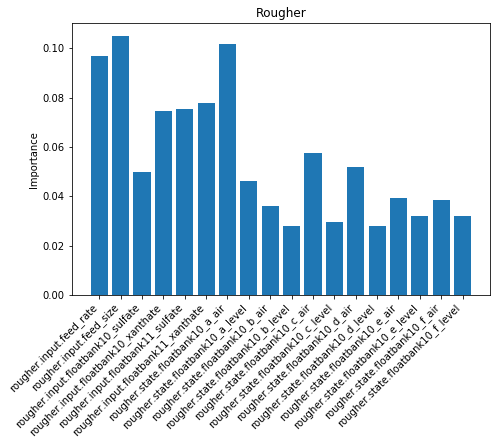

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), sharey=True)
ax.bar(feature_importances.index, feature_importances['importance'])

ax.set_ylabel('Importance')
ax.set_title('Rougher')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.show()

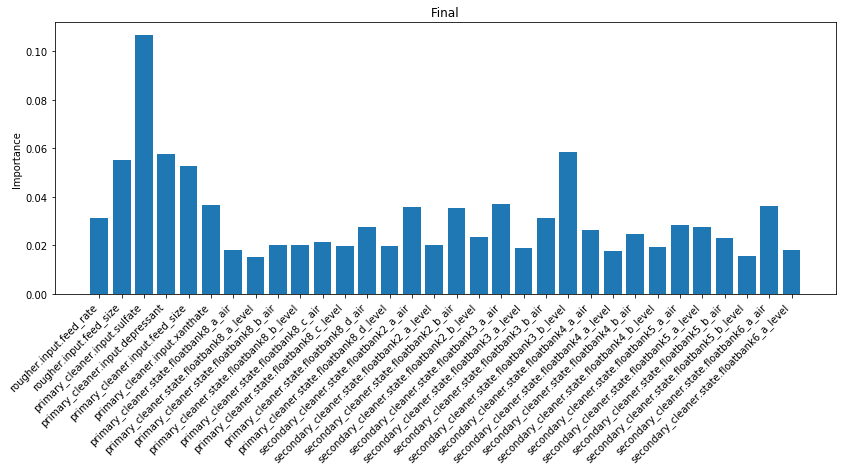

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharey=True)
ax.bar(feature_importances1.index, feature_importances1['importance'])

ax.set_ylabel('Importance')
ax.set_title('Final')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.show()

Становится понятно, что наиболее значимыми признаками являются расход пульпы на входе и размер гранул, расход реагентов. Следом идут значения расхода воздуха. Уровень во флотаторах является наименее значимым.

### 3.3.4. Линейная регрессия
Теперь испытаем линейную регрессию. Масштабирование признаков предоставим модели. Оптимизируем по параметру `fit_intercept`.

In [34]:
%%time
# for information
#LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

# creating model parameter dictionaries
lr_rouger_model_params = {}
lr_rouger_model_params["fit_intercept"] = True
lr_rouger_model_params["normalize"] = True
lr_rouger_model_params["copy_X"] = True

lr_final_model_params = {}
lr_final_model_params["fit_intercept"] = True
lr_final_model_params["normalize"] = True
lr_final_model_params["copy_X"] = True

# optimizing the rougher model
print('optimizing the rougher LR model...')
best_params = optimizer1(rougher_recovery_train, rougher_recovery_target,
              'lr', lr_rouger_model_params, 
              'fit_intercept', [True, False])

lr_best_params = {}
lr_best_params['rougher_params'] = best_params['params'].copy()
lr_best_params['rougher_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nrougher LR optimization has been completed')
print('best rougher sMAPE - {:.4}%'.format(lr_best_params['rougher_sMAPE']))
print('best rougher params:', lr_best_params['rougher_params'])

# optimizing the final model
print('\noptimizing the final LR model...')
best_params = optimizer1(final_recovery_train, final_recovery_target,
              'lr', lr_final_model_params, 
              'fit_intercept', [True, False])

lr_best_params['final_params'] = best_params['params'].copy()
lr_best_params['final_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nfinal LR optimization has been completed')
print('best final sMAPE - {:.4}%'.format(lr_best_params['final_sMAPE']))
print('best final params:', lr_best_params['final_params'])

# summary sMAPE
lr_best_params['sMAPE'] = 0.25 * lr_best_params['rougher_sMAPE'] + 0.75 * lr_best_params['final_sMAPE']
print('\nsummary DT sMAPE = {:.4f}%\n'.format(lr_best_params['sMAPE']))

optimizing the rougher LR model...
turn 0: intermediate sMAPE = 20.97%
turn 1: intermediate sMAPE = 23.86%

rougher LR optimization has been completed
best rougher sMAPE - 20.97%
best rougher params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

optimizing the final LR model...
turn 0: intermediate sMAPE = 15.15%
turn 1: intermediate sMAPE = 15.3%

final LR optimization has been completed
best final sMAPE - 15.15%
best final params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

summary DT sMAPE = 16.6064%

CPU times: user 1.23 s, sys: 1.23 s, total: 2.46 s
Wall time: 2.42 s


Обучим модель на полной обучающей выборке и определим значимость признаков по величине коэффициентов.

In [35]:
lr_best_params['rougher_model'] = LinearRegression().set_params(**lr_best_params['rougher_params'])
lr_best_params['rougher_model'].fit(rougher_recovery_train, rougher_recovery_target)

feature_importances5 = pd.DataFrame(lr_best_params['rougher_model'].coef_, index=rougher_feature_names)
feature_importances5.columns = ['importance']
print('LR rougher feature_importances_:\n', feature_importances5[feature_importances5['importance'] != 0])

LR rougher feature_importances_:
                                     importance
rougher.input.feed_rate              -0.001529
rougher.input.feed_size               0.013865
rougher.input.floatbank10_sulfate     0.469081
rougher.input.floatbank10_xanthate    0.546782
rougher.input.floatbank11_sulfate    -0.774809
rougher.input.floatbank11_xanthate    3.412771
rougher.state.floatbank10_a_air       0.002788
rougher.state.floatbank10_a_level     0.014742
rougher.state.floatbank10_b_air      -0.009984
rougher.state.floatbank10_b_level    -0.042945
rougher.state.floatbank10_c_air      -0.002904
rougher.state.floatbank10_c_level     0.058892
rougher.state.floatbank10_d_air       0.021938
rougher.state.floatbank10_d_level     0.009051
rougher.state.floatbank10_e_air      -0.025314
rougher.state.floatbank10_e_level    -0.028768
rougher.state.floatbank10_f_air       0.013885
rougher.state.floatbank10_f_level     0.017728


In [36]:
lr_best_params['final_model'] = LinearRegression().set_params(**lr_best_params['final_params'])
lr_best_params['final_model'].fit(final_recovery_train, final_recovery_target)

feature_importances6 = pd.DataFrame(lr_best_params['final_model'].coef_, index=final_feature_names)
feature_importances6.columns = ['importance']
print('LR final feature_importances_:\n', feature_importances6[feature_importances6['importance'] != 0])

LR final feature_importances_:
                                             importance
rougher.input.feed_rate                      -0.001377
rougher.input.feed_size                      -0.020735
primary_cleaner.input.sulfate                 0.076200
primary_cleaner.input.depressant             -0.127277
primary_cleaner.input.feed_size               1.187109
primary_cleaner.input.xanthate                1.257109
primary_cleaner.state.floatbank8_a_air       -0.005415
primary_cleaner.state.floatbank8_a_level     -0.006595
primary_cleaner.state.floatbank8_b_air        0.010022
primary_cleaner.state.floatbank8_b_level     -0.040343
primary_cleaner.state.floatbank8_c_air       -0.007381
primary_cleaner.state.floatbank8_c_level      0.031069
primary_cleaner.state.floatbank8_d_air       -0.002807
primary_cleaner.state.floatbank8_d_level      0.006753
secondary_cleaner.state.floatbank2_a_air      0.328783
secondary_cleaner.state.floatbank2_a_level   -0.003603
secondary_cleaner.state.floatbank

Визуализируем.

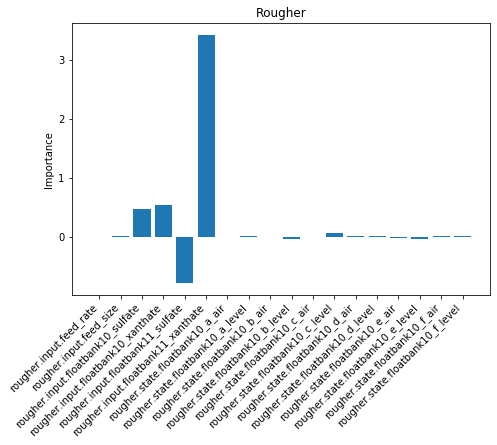

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), sharey=True)
ax.bar(feature_importances5.index, feature_importances5['importance'])

ax.set_ylabel('Importance')
ax.set_title('Rougher')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.show()

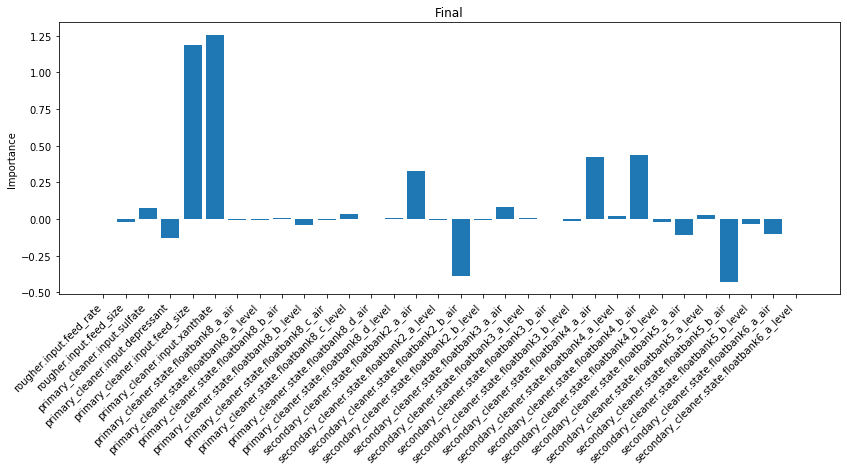

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharey=True)
ax.bar(feature_importances6.index, feature_importances6['importance'])

ax.set_ylabel('Importance')
ax.set_title('Final')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.show()

Наблюдаем примерно ту же картину, что и для случайного леса. Что, если убрать слабо влияющие признаки уровней для грубой и тонкой очистки? Как изменится ошибка моделей?

In [39]:
# for information
#LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

rougher_recovery_train1 = rougher_recovery_train.drop([
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level'], axis=1) 

final_recovery_train1 = final_recovery_train.drop([
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_level',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_level'], axis=1)

# creating model parameter dictionaries
lr_rouger_model_params = {}
lr_rouger_model_params["fit_intercept"] = True
lr_rouger_model_params["normalize"] = True
lr_rouger_model_params["copy_X"] = True

lr_final_model_params = {}
lr_final_model_params["fit_intercept"] = True
lr_final_model_params["normalize"] = True
lr_final_model_params["copy_X"] = True

# optimizing the rougher model
print('optimizing the rougher LR model...')
best_params = optimizer1(rougher_recovery_train1, rougher_recovery_target,
              'lr', lr_rouger_model_params, 
              'fit_intercept', [True, False])

lr_best_params = {}
lr_best_params['rougher_params'] = best_params['params'].copy()
lr_best_params['rougher_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nrougher LR optimization has been completed')
print('best rougher sMAPE - {:.4}%'.format(lr_best_params['rougher_sMAPE']))
print('best rougher params:', lr_best_params['rougher_params'])

# optimizing the final model
print('\noptimizing the final LR model...')
best_params = optimizer1(final_recovery_train1, final_recovery_target,
              'lr', lr_final_model_params, 
              'fit_intercept', [True, False])

lr_best_params['final_params'] = best_params['params'].copy()
lr_best_params['final_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nfinal LR optimization has been completed')
print('best final sMAPE - {:.4}%'.format(lr_best_params['final_sMAPE']))
print('best final params:', lr_best_params['final_params'])

# summary sMAPE
lr_best_params['sMAPE'] = 0.25 * lr_best_params['rougher_sMAPE'] + 0.75 * lr_best_params['final_sMAPE']
print('\nsummary DT sMAPE = {:.4f}%\n'.format(lr_best_params['sMAPE']))

optimizing the rougher LR model...
turn 0: intermediate sMAPE = 20.36%
turn 1: intermediate sMAPE = 25.81%

rougher LR optimization has been completed
best rougher sMAPE - 20.36%
best rougher params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

optimizing the final LR model...
turn 0: intermediate sMAPE = 14.56%
turn 1: intermediate sMAPE = 15.54%

final LR optimization has been completed
best final sMAPE - 14.56%
best final params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

summary DT sMAPE = 16.0071%



Линейная регрессия с уменьшенным набором признаков обогнала решающее дерево.

### 3.3.5. Выбрать лучшую пару для тестирования
Соберём результат исследований в одну таблицу для лучшего обзора.

In [40]:
results = pd.DataFrame([
    [dt_best_params['rougher_sMAPE'], dt_best_params['final_sMAPE'], dt_best_params['sMAPE']],
    [rf_best_params['rougher_sMAPE'], rf_best_params['final_sMAPE'], rf_best_params['sMAPE']],
    [lr_best_params['rougher_sMAPE'], lr_best_params['final_sMAPE'], lr_best_params['sMAPE']]])
results.index = ['DT', 'RF', 'LR']
results.columns = ['rougher_sMAPE', 'final_sMAPE', 'summary_sMAPE']
results

,rougher_sMAPE,final_sMAPE,summary_sMAPE
DT,19.069873,15.323008,16.259724
RF,24.141457,18.720029,20.075386
LR,20.359617,14.556200,16.007055


Лес остался далеко позади. За первое место бились одноуровневое дерево и линейная регрессия. И если бы мы не уменьшли количество признаков для линейной регрессии, дерево бы победило.

Дерево же выбирать не хочется, так как одноуровневое дерево - это практически случайная модель. А нам случайности не нужны.

Выберем линейную регрессию.

## 3.4. Тестирование

In [41]:
# fitting rougher model
lr_best_params['rougher_model'] = LinearRegression().set_params(**lr_best_params['rougher_params'])
lr_best_params['rougher_model'].fit(rougher_recovery_train1, rougher_recovery_target)

# fitting final model
lr_best_params['final_model'] = LinearRegression().set_params(**lr_best_params['final_params'])
lr_best_params['final_model'].fit(final_recovery_train1, final_recovery_target)

rougher_test_features = data_gold_recovery_test[rougher_recovery_train1.columns]
final_test_features = data_gold_recovery_test[final_recovery_train1.columns]

rougher_test_predict = lr_best_params['rougher_model'].predict(rougher_test_features)
rfinal_test_predict = lr_best_params['final_model'].predict(final_test_features)

rougher_sMAPE = sMAPE(rougher_test_predict, 
                      data_gold_recovery_full.loc[data_gold_recovery_test.index, rougher_target_name])
final_sMAPE = sMAPE(rfinal_test_predict, 
                    data_gold_recovery_full.loc[data_gold_recovery_test.index, final_target_name])

print('rougher_sMAPE = {:.4f}%'.format(rougher_sMAPE))
print('final_sMAPE = {:.4f}%'.format(final_sMAPE))
print('summary_sMAPE = {:.4f}%'.format(0.25 * rougher_sMAPE + 0.75 * final_sMAPE))

rougher_sMAPE = 11.2011%
final_sMAPE = 12.4966%
summary_sMAPE = 12.1727%


На тестовой выборке ошибка получилась даже существенно меньше, чем при оптимизации. Это радует. Значит мы на верном пути.

Теперь сравним с константной моделью.

In [42]:
data_gold_recovery_test['rougher_constant'] = data_gold_recovery_full.loc[
    data_gold_recovery_test.index, 'rougher.output.recovery'].mean()
data_gold_recovery_test['final_constant'] = data_gold_recovery_full.loc[
    data_gold_recovery_test.index, 'final.output.recovery'].mean()

rougher_c_sMAPE = sMAPE(rougher_test_predict, data_gold_recovery_test['rougher_constant'])
final_c_sMAPE = sMAPE(rfinal_test_predict, data_gold_recovery_test['final_constant'])

print('rougher_c_sMAPE = {:.4f}%'.format(rougher_c_sMAPE))
print('final_c_sMAPE = {:.4f}%'.format(final_c_sMAPE))
print('summary_c_sMAPE = {:.4f}%'.format(0.25 * rougher_c_sMAPE + 0.75 * final_c_sMAPE))

rougher_c_sMAPE = 4.6688%
final_c_sMAPE = 7.7364%
summary_c_sMAPE = 6.9695%


Константная модель оказалась в 2 раза лучше. Может, и правда, отвечать на всё средним и ладно?

Попробуем ещё исключить из обучающей выборки нулевые концентрации, обучить и заново проверить.

In [44]:
# rougher train datasets
rougher_recovery_train21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 0, 
                                                        rougher_feature_names]
rougher_recovery_target21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 0,
                                                         rougher_target_name]

# final train datasets
final_recovery_train21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 0,
                                                      final_feature_names]
final_recovery_target21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 0,
                                                       final_target_name]


# fitting rougher model
lr_best_params['rougher_model'] = LinearRegression().set_params(**lr_best_params['rougher_params'])
lr_best_params['rougher_model'].fit(rougher_recovery_train21, rougher_recovery_target21)

# fitting final model
lr_best_params['final_model'] = LinearRegression().set_params(**lr_best_params['final_params'])
lr_best_params['final_model'].fit(final_recovery_train21, final_recovery_target21)

rougher_test_features = data_gold_recovery_test[rougher_recovery_train21.columns]
final_test_features = data_gold_recovery_test[final_recovery_train21.columns]

rougher_test_predict = lr_best_params['rougher_model'].predict(rougher_test_features)
rfinal_test_predict = lr_best_params['final_model'].predict(final_test_features)

rougher_sMAPE = sMAPE(rougher_test_predict, 
                      data_gold_recovery_full.loc[data_gold_recovery_test.index, rougher_target_name])
final_sMAPE = sMAPE(rfinal_test_predict, 
                    data_gold_recovery_full.loc[data_gold_recovery_test.index, final_target_name])

print('rougher_sMAPE = {:.4f}%'.format(rougher_sMAPE))
print('final_sMAPE = {:.4f}%'.format(final_sMAPE))
print('summary_sMAPE = {:.4f}%'.format(0.25 * rougher_sMAPE + 0.75 * final_sMAPE))

rougher_sMAPE = 11.1057%
final_sMAPE = 13.4545%
summary_sMAPE = 12.8673%


Не получилось.

Попробуем ещё исключить из обучающей выборки концентрации меньше единицы.

In [45]:
# rougher train datasets
rougher_recovery_train21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 1, 
                                                        rougher_feature_names]
rougher_recovery_target21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 1,
                                                         rougher_target_name]

# final train datasets
final_recovery_train21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 1,
                                                      final_feature_names]
final_recovery_target21 = data_gold_recovery_train.loc[data_gold_recovery_train['rougher.input.feed_au'] > 1,
                                                       final_target_name]


# fitting rougher model
lr_best_params['rougher_model'] = LinearRegression().set_params(**lr_best_params['rougher_params'])
lr_best_params['rougher_model'].fit(rougher_recovery_train21, rougher_recovery_target21)

# fitting final model
lr_best_params['final_model'] = LinearRegression().set_params(**lr_best_params['final_params'])
lr_best_params['final_model'].fit(final_recovery_train21, final_recovery_target21)

rougher_test_features = data_gold_recovery_test[rougher_recovery_train21.columns]
final_test_features = data_gold_recovery_test[final_recovery_train21.columns]

rougher_test_predict = lr_best_params['rougher_model'].predict(rougher_test_features)
rfinal_test_predict = lr_best_params['final_model'].predict(final_test_features)

rougher_sMAPE = sMAPE(rougher_test_predict, 
                      data_gold_recovery_full.loc[data_gold_recovery_test.index, rougher_target_name])
final_sMAPE = sMAPE(rfinal_test_predict, 
                    data_gold_recovery_full.loc[data_gold_recovery_test.index, final_target_name])

print('rougher_sMAPE = {:.4f}%'.format(rougher_sMAPE))
print('final_sMAPE = {:.4f}%'.format(final_sMAPE))
print('summary_sMAPE = {:.4f}%'.format(0.25 * rougher_sMAPE + 0.75 * final_sMAPE))

rougher_sMAPE = 11.8815%
final_sMAPE = 12.4549%
summary_sMAPE = 12.3115%


Снова не получилось.

Вдохновившись тем, что удаление пустых recovery сильно улучшило МАЕ, возникла идея попытать модель с удалёнными пропусками таргетов и признаков, а не заполненными. Попробуем на линейной регрессии, она считается быстро. Для чистоты эксперимента скачаем датасеты заново.

In [46]:
# loading files anew
data_gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')
print(data_gold_recovery_train.shape, data_gold_recovery_test.shape, data_gold_recovery_full.shape)

(16860, 87) (5856, 53) (22716, 87)


In [47]:
# setting index
print('data_gold_recovery_train index type -', to_datetime(data_gold_recovery_train).dtype.name)
print('data_gold_recovery_test index type -', to_datetime(data_gold_recovery_test).dtype.name)
print('data_gold_recovery_full index type -', to_datetime(data_gold_recovery_full).dtype.name)

data_gold_recovery_train index type - datetime64[ns]
data_gold_recovery_test index type - datetime64[ns]
data_gold_recovery_full index type - datetime64[ns]


In [48]:
# rougher train datasets
rougher_recovery_train_features = data_gold_recovery_train.loc[
    data_gold_recovery_train[rougher_target_name].dropna().index, rougher_feature_names].dropna()
rougher_recovery_train_target = (data_gold_recovery_train.loc[
    rougher_recovery_train_features.index, [rougher_target_name]])[rougher_target_name]

# final train datasets
final_recovery_train_features = data_gold_recovery_train.loc[
    data_gold_recovery_train[final_target_name].dropna().index, final_feature_names].dropna()
final_recovery_train_target = (data_gold_recovery_train.loc[
    final_recovery_train_features.index, [final_target_name]])[final_target_name]

print(rougher_recovery_train_features.shape, rougher_recovery_train_target.shape, 
      final_recovery_train_features.shape, final_recovery_train_target.shape)

(13241, 18) (13241,) (14423, 32) (14423,)


In [49]:
%%time
# strange warnings raised
import warnings
warnings.filterwarnings('ignore')

# for information
#LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)

# creating model parameter dictionaries
lr_rouger_model_params = {}
lr_rouger_model_params["fit_intercept"] = True
lr_rouger_model_params["normalize"] = True
lr_rouger_model_params["copy_X"] = True

lr_final_model_params = {}
lr_final_model_params["fit_intercept"] = True
lr_final_model_params["normalize"] = True
lr_final_model_params["copy_X"] = True

# optimizing the rougher model
print('optimizing the rougher LR model...')
best_params = optimizer1(rougher_recovery_train, rougher_recovery_target,
              'lr', lr_rouger_model_params, 
              'fit_intercept', [True, False])

lr_best_params = {}
lr_best_params['rougher_params'] = best_params['params'].copy()
lr_best_params['rougher_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nrougher LR optimization has been completed')
print('best rougher sMAPE - {:.4}%'.format(lr_best_params['rougher_sMAPE']))
print('best rougher params:', lr_best_params['rougher_params'])

# optimizing the final model
print('\noptimizing the final LR model...')
best_params = optimizer1(final_recovery_train, final_recovery_target,
              'lr', lr_final_model_params, 
              'fit_intercept', [True, False])

lr_best_params['final_params'] = best_params['params'].copy()
lr_best_params['final_sMAPE'] = best_params['sMAPE']

# optimization finished
print('\nfinal LR optimization has been completed')
print('best final sMAPE - {:.4}%'.format(lr_best_params['final_sMAPE']))
print('best final params:', lr_best_params['final_params'])

# summary sMAPE
lr_best_params['sMAPE'] = 0.25 * lr_best_params['rougher_sMAPE'] + 0.75 * lr_best_params['final_sMAPE']
print('\nsummary DT sMAPE = {:.4f}%\n'.format(lr_best_params['sMAPE']))

optimizing the rougher LR model...
turn 0: intermediate sMAPE = 20.97%
turn 1: intermediate sMAPE = 23.86%

rougher LR optimization has been completed
best rougher sMAPE - 20.97%
best rougher params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

optimizing the final LR model...
turn 0: intermediate sMAPE = 15.15%
turn 1: intermediate sMAPE = 15.3%

final LR optimization has been completed
best final sMAPE - 15.15%
best final params: {'fit_intercept': True, 'normalize': True, 'copy_X': True}

summary DT sMAPE = 16.6064%

CPU times: user 1.25 s, sys: 1.13 s, total: 2.38 s
Wall time: 2.35 s


Метрика существенно не улучшилась. Протестируем. Из тестовых наборов так же удалим пропуски.

In [50]:
# making rougher test datasets
rougher_recovery_test_target = data_gold_recovery_full.loc[
    data_gold_recovery_test.index, [rougher_target_name]].dropna()
rougher_recovery_test_features = data_gold_recovery_test.loc[
    rougher_recovery_test_target.index, rougher_feature_names].dropna()
rougher_recovery_test_target = (data_gold_recovery_full.loc[
    rougher_recovery_test_features.index, [rougher_target_name]])[rougher_target_name]

# making final test datasets
final_recovery_test_target = data_gold_recovery_full.loc[
    data_gold_recovery_test.index, [final_target_name]].dropna()
final_recovery_test_features = data_gold_recovery_test.loc[
    final_recovery_test_target.index, final_feature_names].dropna()
final_recovery_test_target = (data_gold_recovery_full.loc[
    final_recovery_test_features.index, [final_target_name]])[final_target_name]

print(rougher_recovery_test_features.shape, rougher_recovery_test_target.shape, 
      final_recovery_test_features.shape, final_recovery_test_target.shape)

(5279, 18) (5279,) (5387, 32) (5387,)


In [51]:
# fitting rougher model
lr_best_params['rougher_model'] = LinearRegression().set_params(**lr_best_params['rougher_params'])
lr_best_params['rougher_model'].fit(rougher_recovery_train, rougher_recovery_target)

# fitting final model
lr_best_params['final_model'] = LinearRegression().set_params(**lr_best_params['final_params'])
lr_best_params['final_model'].fit(final_recovery_train, final_recovery_target)

rougher_test_predict = lr_best_params['rougher_model'].predict(rougher_recovery_test_features)
final_test_predict = lr_best_params['final_model'].predict(final_recovery_test_features)

rougher_sMAPE = sMAPE(rougher_test_predict, rougher_recovery_test_target)
final_sMAPE = sMAPE(final_test_predict, final_recovery_test_target)

print('rougher_sMAPE = ', rougher_sMAPE)
print('final_sMAPE = {:.4f}%'.format(final_sMAPE))
print('summary_sMAPE = {:.4f}%'.format(0.25 * rougher_sMAPE + 0.75 * final_sMAPE))

rougher_sMAPE =  9.878365942213003
final_sMAPE = 10.0263%
summary_sMAPE = 9.9893%


Существенно лучше. Сравним с константной, заполненной средним из обучающего набора.

In [53]:
rougher_recovery_constant_target = pd.Series(rougher_recovery_target.mean(), index=rougher_recovery_train_target.index)
final_recovery_constant_target = pd.Series(final_recovery_target.mean(), index=final_recovery_train_target.index)

rougher_c_sMAPE = sMAPE(rougher_recovery_constant_target, rougher_recovery_train_target)
final_c_sMAPE = sMAPE(final_recovery_constant_target, final_recovery_train_target)

print('rougher_c_sMAPE = {:.4f}%'.format(rougher_c_sMAPE))
print('final_c_sMAPE = {:.4f}%'.format(final_c_sMAPE))
print('summary_c_sMAPE = {:.4f}%'.format(0.25 * rougher_c_sMAPE + 0.75 * final_c_sMAPE))

rougher_c_sMAPE = 12.2875%
final_c_sMAPE = 11.1544%
summary_c_sMAPE = 11.4377%


Справедливость восторжествовала. Модель на 1,5% лучше константной.

## 3.5. Выводы
Сформулируем общие выводы.
1. Исследование данных привело к выводу, что показатели концентрации в предоставленном заказчиком датасете являются недостоверными. Было решено обратить внимание заказчика на этот факт.
2. Путём математического исследования было выявлено, что показатели концентрации не влияют на значения `recovery`. Учитывая это и то, что они недостоверны в имеющемся наборе данных, было решено исключить их числа признаков для обучения модели.
3. В качестве обучающих признаков были отобраны первичные технологические параметры для стадий грубой и тонкой очистки. В качестве целевых признаков выбраны значения `recovery` обеих стадий.
4. Была проведена оптимизация и исследованы значения sMAPE для 3-х типов моделей: решающее дерево, случайный лес и линейная регрессия. Была выбрана линейная регрессия из следующих соображений:
- Показала лучшие значения sMAPE вместе с решающим деревом,
- Требует горазо меньше процессорного времени для обучения и предсказания,
- Использует все признаки, в отличие от одноуровневого решающего дерева, поэтому будет более устойчивым при различных сочетаниях признаков.
5. Была проведена оптимизация обучающих признаков для линейной регрессии, что вывело её на первое место. Были исключены показатели уровня пульпы во флотаторах. Это соответствует природе процесса, так как количество воздуха оказывает гораздо большее влияние на пенообразование, чем уровень пульпы.
6. Было проведено обучение выбранных моделей линейной регрессии для стадий грубой и тонкой очистки.
7. Проведена проверка выбранных обученных моделей на тестовом наборе. Итоговая sMAPE составила 12,17%. Вывод - рекомендовать модель для дальнейшей эксплуатации.